/tmp/ipykernel_19/2429206668.py:106: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_19/2429206668.py:109: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum  -2.923723
1  Spectrum_1   -0.998045  Full_Spectrum  -2.839408
2  Spectrum_1   -0.996090  Full_Spectrum  -2.867009
3  Spectrum_1   -0.994135  Full_Spectrum  -2.639834
4  Spectrum_1   -0.992180  Full_Spectrum  -2.824436
Cosmic Ray Peaks for Spectrum 1:
Position: -0.6559139784946236, Intensity: 1.2471900412814834
Position: -0.6480938416422287, Intensity: 0.9250277678131986
Position: -0.6441837732160313, Intensity: 1.1229430834354313
Position: -0.6363636363636364, Intensity: 0.9857310855675441
Position: -0.6324535679374389, Intensity: 1.4255962657384735
Cosmic Ray Peaks for Spectrum 2:
Position: 0.14760508308895415, Intensity: 1.356861629211198
Position: 0.26099706744868034, Intensity: 0.9780496907669918
Position: 0.2785923753665689, Intensity: 1.1154441227457468
Position: 0.2864125122189638, Intensity: 0.9295308758895606
Position: 0.29032258064516125, Intensity: 0.937714383096701
Cosmic Ray Peaks

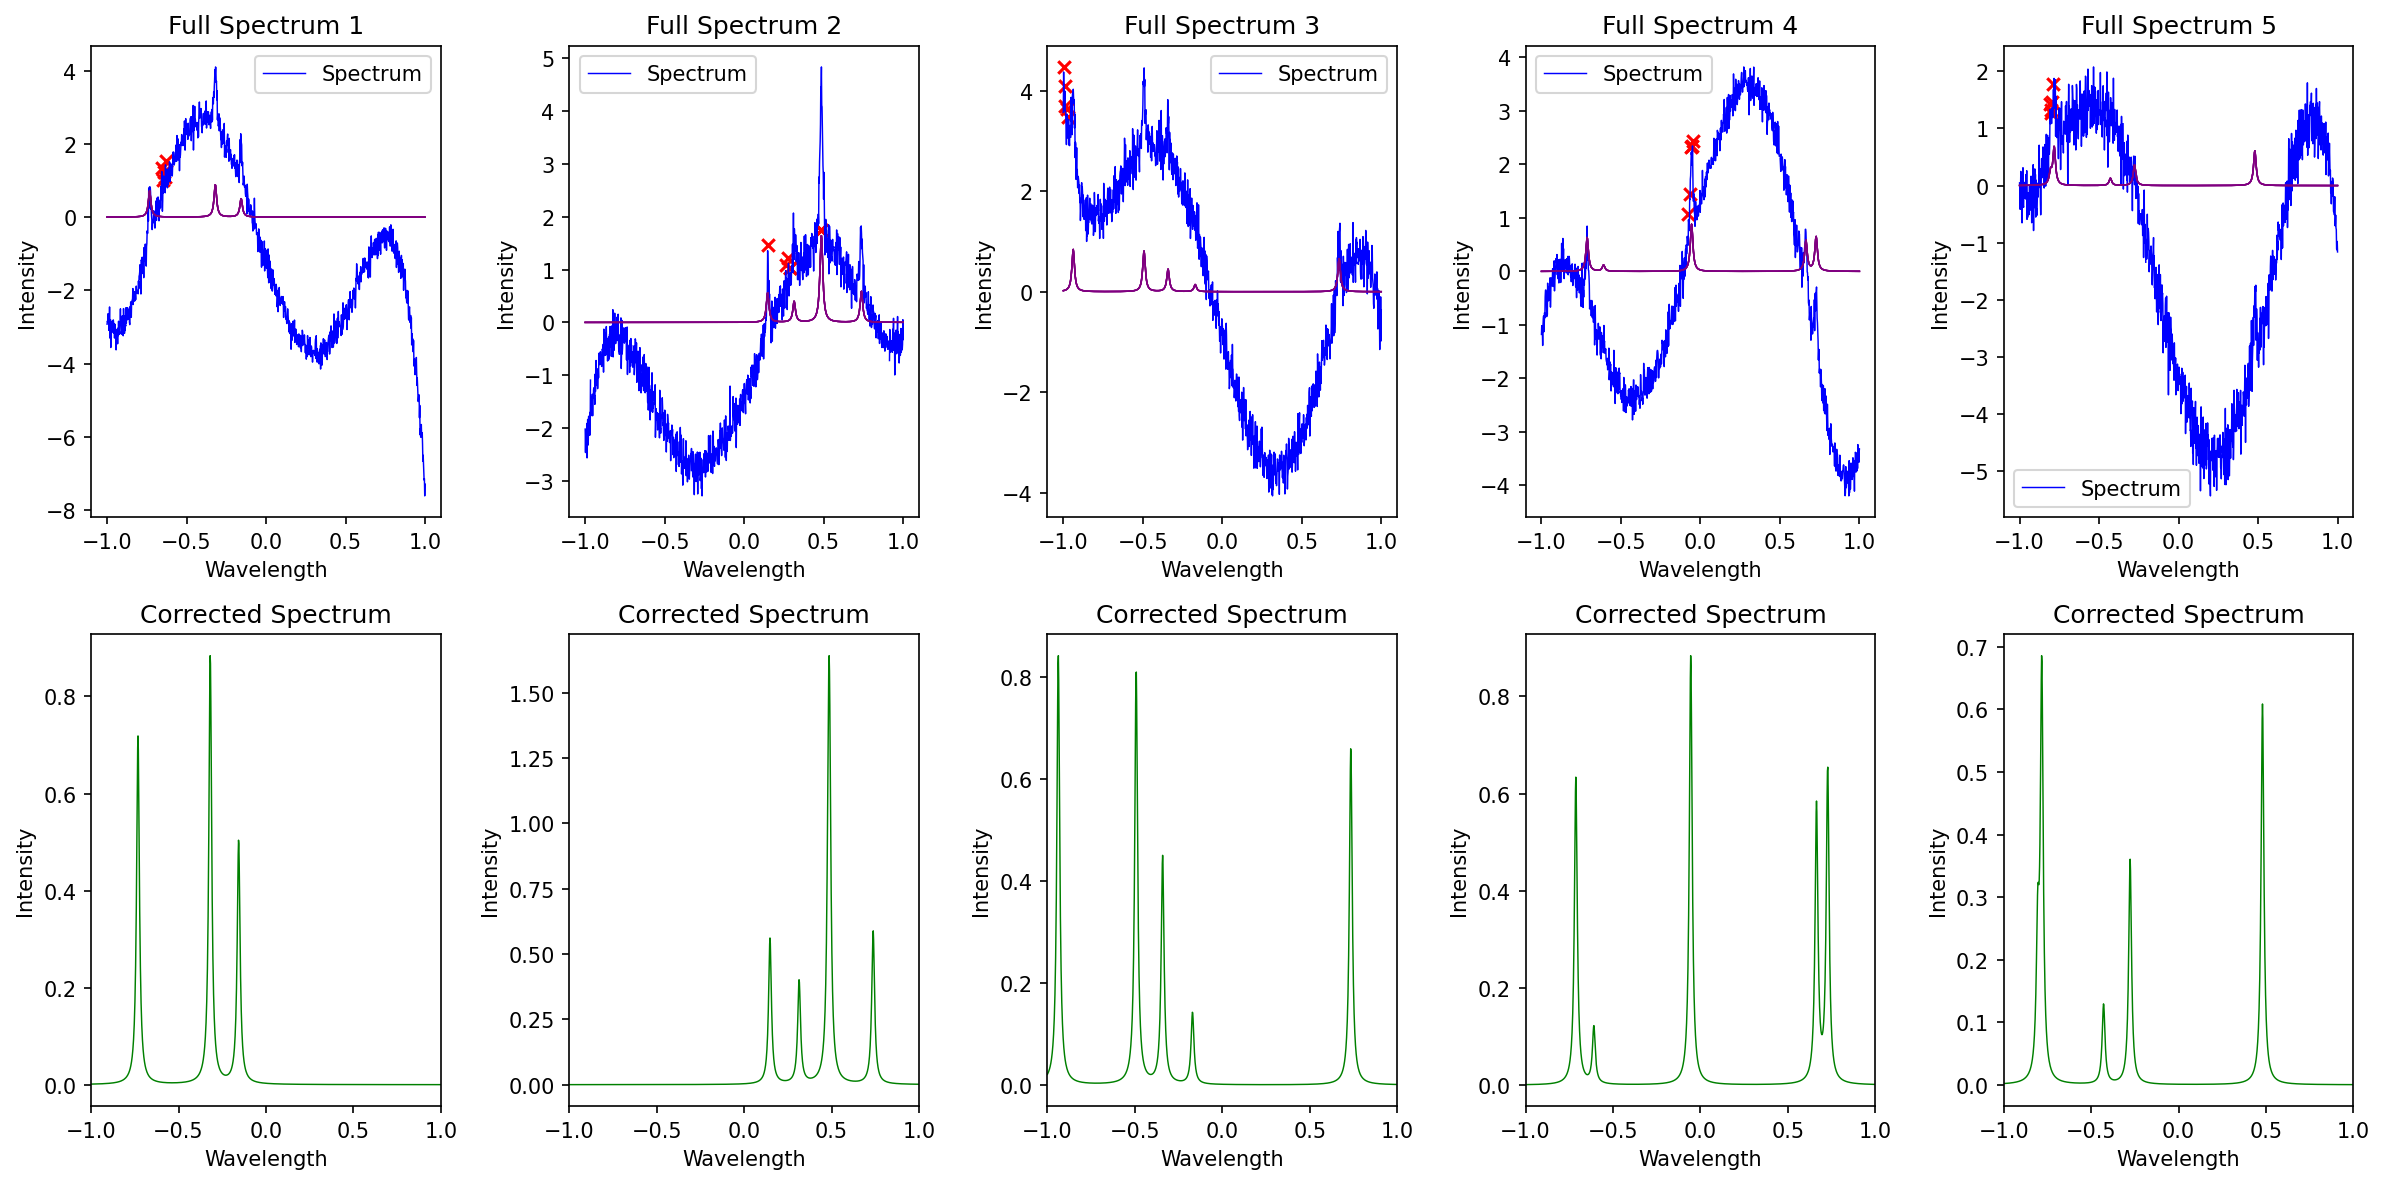

In [1]:
# SYNTHETIC SPECTRA (mark cosmic rays, new structure, best resolution)
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 1 & 5
    num_cosmic_rays = np.random.randint(1, 5)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Set up a figure with higher resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra with cosmic rays marked
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 0.9

    # Filter peaks (only include those above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: synthetic_data_generator.full_spectra_list[i][peak], reverse=True)

    # Count how many cosmic ray peaks were identified
    num_cosmic_rays = len(sorted_cosmic_ray_peaks)

    # Determine the number of cosmic rays to mark, capped at 5
    num_cosmic_rays_to_mark = min(5, num_cosmic_rays)
    
    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.10, marker='x', color='red')

    # Adjust plot settings
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    
    # Print peak information
    print(f'Cosmic Ray Peaks for Spectrum {i + 1}:')
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        print(f'Position: {synthetic_data_generator.wavelengths[peak]}, Intensity: {synthetic_data_generator.full_spectra_list[i][peak]}')

# Plot corrected spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7)
    plt.title('Corrected Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())

    for i in range(num_spectra):
        plt.subplot(2, num_spectra, i + 1)

        # Plot with a smoother line & more data points
        plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='purple', label='Spectrum', linewidth=0.7)

        # Identify cosmic ray positions based on local maxima
        peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.raman_spectra_list[i])

        # Set a threshold to distinguish cosmic rays from other peaks
        cosmic_ray_threshold = 0.9

        # Filter peaks (only include those above threshold)
        cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.raman_spectra_list[i][peak] > cosmic_ray_threshold]

        # Mark cosmic ray positions with "x" above peaks
        for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
            # Mark cosmic ray with "x" above peak
            plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.raman_spectra_list[i][peak] + 0.10, marker='x', color='red')
    
# Adjust layout
plt.tight_layout()
plt.show()  

Cosmic Ray Indices for Spectrum 1: [   9   11  108  117  132  134  166  186  223  232  247  270  277  319
  338  354  377  391  424  428  449  496  504  506  516  519  549  591
  603  671  686  688  691  757  840  846  869  871  879  898  930  944
  953  979 1004 1006 1022]
Cosmic Ray Indices for Spectrum 2: [   5   15   58   83   89  115  135  142  168  202  205  225  238  274
  292  307  309  313  324  361  373  375  409  450  466  485  497  601
  611  633  667  703  724  750  766  770  783  809  822  841  847  856
  894  995 1005]
Cosmic Ray Indices for Spectrum 3: [  27   37   40   71   74   76  128  161  168  176  179  192  198  200
  206  214  221  224  233  244  262  283  302  313  315  320  333  340
  352  370  401  408  425  436  459  480  491  505  522  542  561  563
  574  576  585  587  597  604  612  618  623  660  664  670  672  694
  707  742  753  792  816  848  863  867  869  872  882  884  886  891
  893  899  910  914  923  932  939  941  977 1014 1017 1019 1021]
Cos

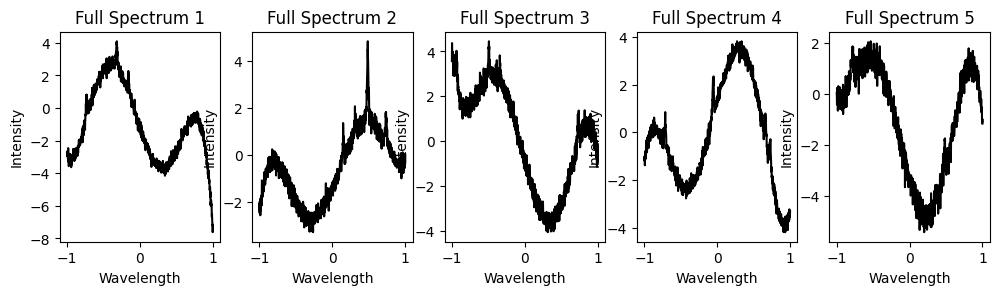

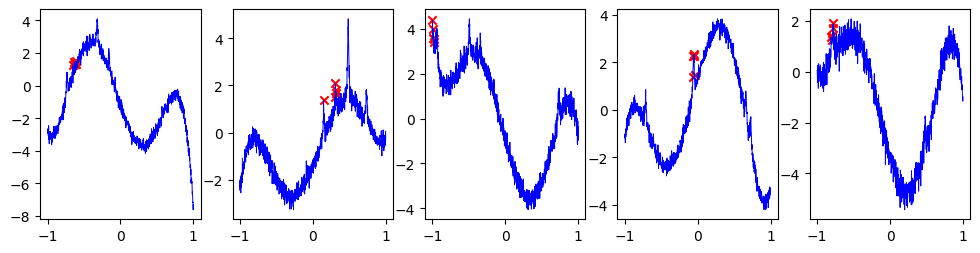

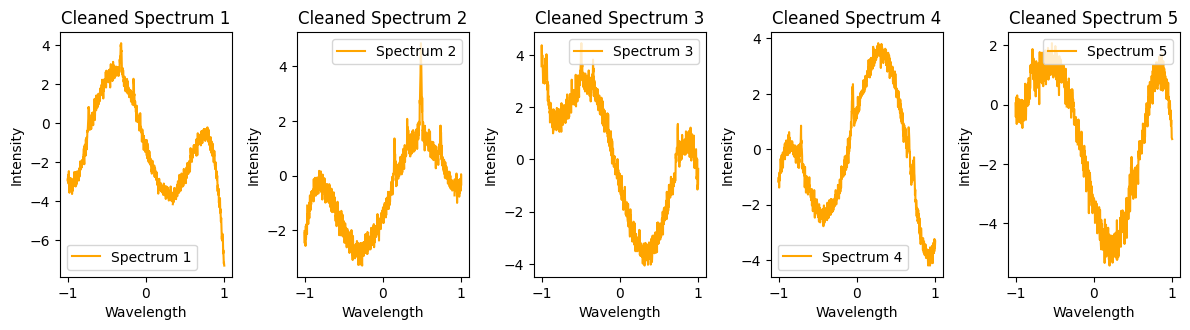

Value at index 7: 1.174933620995197
Value at index 23: 1.2029323596913373
Value at index 35: 1.0356047905685823
Value at index 42: 1.1585324488522304
Value at index 44: 2.090912025100013


In [2]:
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Extract individual spectra
for spectrum_id in spectrum_ids:
    # Filter data for current spectrum ID
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]

    # Extract wavelength & intensity data
    wavelength = spectrum_data['Wavelength']
    intensity = spectrum_data['Intensity']

# Initialize a list to store cleaned spectra
cleaned_spectra = []


# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]  # Use df instead of data

    # Check if spectrum exists in data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 0.9
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)             
        
        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='black')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 1.2

    # Filter peaks (only include those above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

     
    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.02, marker='x', color='red')


# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], color='orange', label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Print values at some cosmic ray indices for analysis
for index in cosmic_ray_indices[:5]:  # Print values for the first 5 indices
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")